<a href="https://colab.research.google.com/github/sharonapa/pytorch-classification/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from torch import  nn
import torch.nn.functional as F

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [0]:
!ls 

ants_and_bees  sample_data


In [0]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0,shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1,saturation=1),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ])

training_dataset = datasets.ImageFolder(root='ants_and_bees/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(dataset= training_dataset, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset= val_dataset, batch_size=20, shuffle=False)

In [0]:
def img_convert(tensor):
  image = tensor.cpu().clone().detach().numpy() #(1,28,28), so to plot it we need :
  image = image.transpose(1,2,0) #(28,28,1)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)) #doing de-normalizaion
  image= image.clip(0, 1)
  return image

In [0]:
classes = ('ants', 'bees')

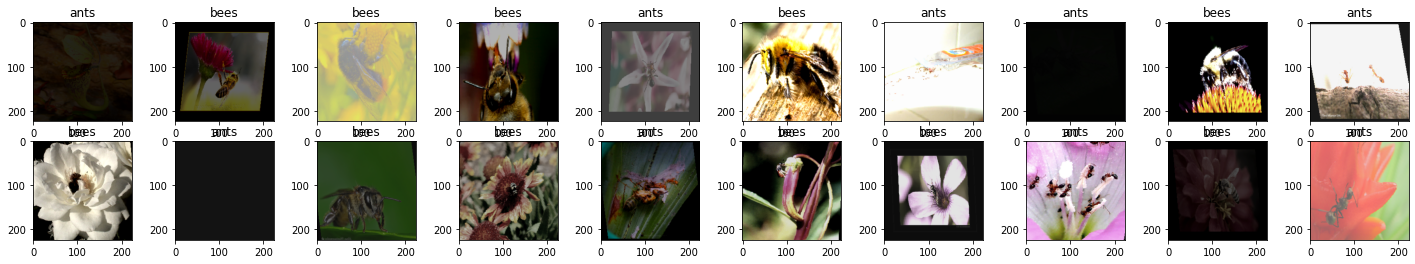

In [0]:
dataiter =  iter(training_loader)
images , labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax =fig.add_subplot(2,10, idx+1)
  plt.imshow(img_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [0]:
model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in model.features.parameters():
  param.requires_grad = False

In [0]:
n_input = model.classifier[6].in_features
last_layer = nn.Linear(n_input , len(classes))
model.classifier[6] = last_layer
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [0]:
epochs = 10
running_loss_history = []
running_corrects_history =[] #we just want to see how many correct we get while training

val_running_loss_history = []
val_running_corrects_history = []


for i in range(epochs):
  running_loss = 0.0
  running_correct = 0.0

  val_running_loss = 0.0
  val_running_correct = 0.0

  for inputs, labels in training_loader: # looping batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    #inputs = inputs.view(inputs.shape[0], -1) #1, 28,28 -> 1, 784 
    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    running_loss+= loss.item()
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds= torch.max(outputs, 1)
    running_correct += torch.sum(preds == labels.data)
  else:
    #finished current epoch, let's check on val data
    with torch.no_grad():
      model.eval()
      for val_inputs, val_labels in val_loader: # looping batch
        #val_inputs = val_inputs.view(val_inputs.shape[0], -1) #1, 28,28 -> 1, 784 
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)

        val_outputs = model.forward(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss+= val_loss.item()
        
        _, val_preds= torch.max(val_outputs, 1)
        val_running_correct += torch.sum(val_preds == val_labels.data)
      

    print("finished training on epoch : {}".format(i))

    current_avg_epoch_acc = running_correct/len(training_loader.dataset)
    running_corrects_history.append(current_avg_epoch_acc)

    current_avg_epoch_loss =running_loss/len(training_loader.dataset)
    running_loss_history.append(current_avg_epoch_loss)
    
    print("training loss: {:.4f}, acc: {:.4f}".format(current_avg_epoch_loss,current_avg_epoch_acc))

    current_val_avg_epoch_acc = val_running_correct/len(val_loader.dataset)
    val_running_corrects_history.append(current_val_avg_epoch_acc)

    current_val_avg_epoch_loss =val_running_loss/len(val_loader.dataset)
    val_running_loss_history.append(current_val_avg_epoch_loss)
    
    print("val loss: {:.4f}, acc: {:.4f}".format(current_val_avg_epoch_loss,current_val_avg_epoch_acc))




finished training on epoch : 0
training loss: 0.0627, acc: 0.6721
val loss: 0.0305, acc: 0.7974
finished training on epoch : 1
training loss: 0.0392, acc: 0.7008
val loss: 0.0308, acc: 0.8366
finished training on epoch : 2
training loss: 0.0430, acc: 0.6926
val loss: 0.0435, acc: 0.6667
finished training on epoch : 3
training loss: 0.0284, acc: 0.7213
val loss: 0.0211, acc: 0.8562
finished training on epoch : 4
training loss: 0.0207, acc: 0.7910
val loss: 0.0277, acc: 0.8431
finished training on epoch : 5
training loss: 0.0198, acc: 0.8279
val loss: 0.0254, acc: 0.8431
finished training on epoch : 6
training loss: 0.0212, acc: 0.8361
val loss: 0.0232, acc: 0.8562
finished training on epoch : 7
training loss: 0.0162, acc: 0.8443
val loss: 0.0527, acc: 0.7778
finished training on epoch : 8
training loss: 0.0225, acc: 0.7705
val loss: 0.0271, acc: 0.8431
finished training on epoch : 9
training loss: 0.0152, acc: 0.8484
val loss: 0.0333, acc: 0.8562


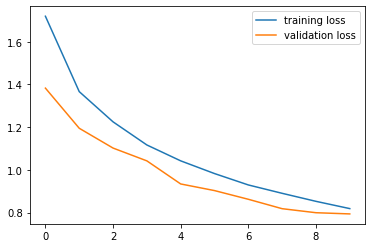

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

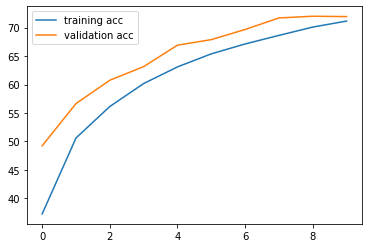

In [0]:
plt.plot(running_corrects_history, label='training acc')
plt.plot(val_running_corrects_history, label='validation acc')
plt.legend()

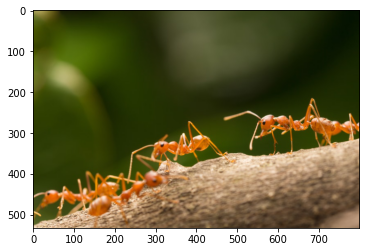

In [0]:
import requests
from PIL import  Image
url = 'https://cdn-prod.servicemaster.com/-/media/Feature/Terminix/Blogs/red-ants-marching-main.jpg?rev=7bf15528c8c14deea7fc30f8d27b8fe4&h=533&w=800&la=en&hash=5D24F94F7C19023A61756535BD8B8A1F'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img);


'ants'

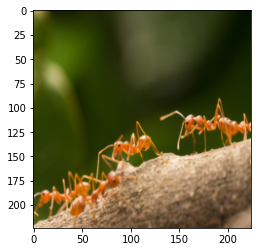

In [0]:
#preprocess image
import PIL
response = requests.get(url, stream = True)
img = Image.open(response.raw)
img = transform(img)
plt.imshow(img_convert(img))

#  infrence
img = img.to(device).unsqueeze(0)

#img = img.view(img.shape[0],-1)
score = model.forward(img)

_, pred = torch.max(score,1)
classes[pred.item()]

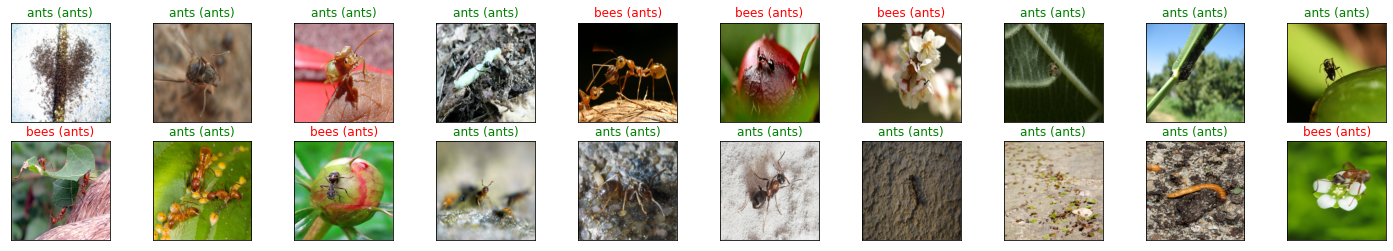

In [0]:

dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
labels = labels.cuda()


#images_ = images.view(images.shape[0], -1)
model.eval()
model = model.cuda()
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(img_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

